In [21]:
import vasp_example as vex
from vasp_example import load_dbenv_if_not_loaded, get_data_cls
load_dbenv_if_not_loaded()

In [52]:
import datetime
import time
import numpy as np
from aiida.orm import DataFactory, CalculationFactory, Code, load_node, load_workflow
from aiida.tools.data.array.kpoints import get_explicit_kpoints_path
from aiida.work import run, submit

In [28]:
import numpy


def create_structure_Si():
    structure_cls = get_data_cls('structure')
    alat = 5.4
    structure = structure_cls(cell=numpy.array([[.5, 0, .5], [.5, .5, 0], [0, .5, .5]]) * alat)
    structure.append_atom(position=numpy.array([.25, .25, .25]) * alat, symbols='Si')
    return structure


def create_kpoints_path():
    return get_explicit_kpoints_path(structure=create_structure_Si())


def create_params_simple():
    param_cls = get_data_cls('parameter')
    return param_cls(dict={'prec': 'NORMAL', 'encut': 200, 'ediff': 1e-8, 'ialgo': 38, 'ismear': 0, 'sigma': 0.1})


def import_pots(folder_path, family_name):
    pot_cls = get_data_cls('vasp.potcar')
    pot_cls.upload_potcar_family(folder_path, group_name=family_name, group_description='Test family', stop_if_existing=False)


In [4]:
proc = CalculationFactory('vasp.vasp').process()

In [44]:
def make_example_inputs():
    import numpy as np
    potcar_cls = get_data_cls('vasp.potcar')
    inputs = proc.get_inputs_template()
    potcar_map = {'Si': 'Si'}
    auto_kpoints = create_kpoints_path()
    inputs._label = 'Test {}'.format(vex.now_str())
    inputs.code = 'vasp@monch'
    inputs._description = 'This is a test'
    inputs._options.max_wallclock_seconds = 3000
    inputs._options.resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 20}
    inputs._options.queue_name = 'dphys_compute'
    inputs._options.computer = Code.get_from_string(inputs['code']).get_computer()
    inputs.kpoints = DataFactory('array.kpoints')(kpoints_mesh=[10, 10, 10])  # auto_kpoints['explicit_kpoints']
    inputs.parameters = create_params_simple()
    inputs.structure = vex.new_or_existing_structure(auto_kpoints['conv_structure'])
    inputs.potential = potcar_cls.get_potcars_from_structure(family_name='PBE', structure=inputs.structure, mapping=potcar_map)
    inputs.settings = DataFactory('parameter')(dict={'parser_settings':{'add_structure': True}})
    inputs['code'] = Code.get_from_string('vasp')
    return inputs

In [54]:
def run_example():
    return submit(proc, **make_example_inputs())

In [33]:
def poll_calc(running):
    result = load_node(running.pid)
    state = result.get_state()
    while not state in ['FINISHED', 'FAILED', 'PARSINGFAILED']:
        result = load_node(running.pid)
        state = result.get_state()
        print state
        time.sleep(10)
    print result.get_state

In [57]:
running = run_example()

ModificationNotAllowed: Can add an output node to a calculation only if it is in one of the following states: [u'SUBMITTING', u'RETRIEVING', u'PARSING'], it is instead FINISHED

In [ ]:
poll_calc(running)

In [49]:
running.pid

2424

In [8]:
def show_bands(calc):
    result.out.output_band.show_mpl()

In [9]:
# Main imports for UI
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Javascript
from fileupload import FileUploadWidget
from phono_ui import show_warning, init_warnings, nice_errors

In [10]:
init_warnings()

A Jupyter Widget

In [11]:
structure = None

upload_out = widgets.HTML()

@nice_errors(default_return=None)
def on_file_upload(c):
    global structure, upload_out
    
    from aiida.orm import DataFactory
    StructureData = DataFactory('structure')
    
    import ase, ase.io
    from tempfile import NamedTemporaryFile
    
    upload_out.value = "Uploading structure..."
    tmp = NamedTemporaryFile(suffix=in_file_upload.filename)
    f = open(tmp.name, "w")
    f.write(in_file_upload.data)
    f.close()
    if tmp.name.endswith('.aiida'):
        from aiida.orm.importexport import import_data
        upload_out.value = "Importing data..."
        import_dict = import_data(tmp.name,silent=True)
        qs = StructureData.query(pk__in=[_[1] for _ in import_dict['Node']['existing']+import_dict['Node']['new']])
        if qs.count()==0:
            raise ValueError("No structure found!")
        if qs.count() > 1:
            upload_out.value = "<strong>Number of structures found</strong>: %d; considering only the first one.<br>"%qs.count()
        else:
            upload_out.value = "<strong>Structure loaded.</strong><br>"    
        structure = qs.first()
    else:
        ase_structures = ase.io.read(tmp.name, index=":")
        if len(ase_structures) > 1:
            upload_out.value = "<strong>Number of structures found</strong>: %d; considering only the first one.<br>"%len(ase_structure)
        else:
            upload_out.value = "<strong>Structure loaded.</strong><br>"
        ase_structure = ase_structures[0]
        structure = StructureData(ase = ase_structure)
    tmp.close()
    #update_view()
    upload_out.value += '\nStructure chemical formula: <strong>%s</strong>.' % structure.get_formula()
    
#TODO: FileUploadWidget doesn't fire event when same file is uploaded twice
in_file_upload = FileUploadWidget("Upload Structure")
in_file_upload.observe(on_file_upload, names='data')

in_use_example_structure = widgets.Checkbox(
    value=False,
    description='Use an example structure',
    disabled=False
)

example_structure_options = [['Diamond', 'diamond'], ['Aluminum', 'al'],['GaAs', 'gaas'], ['Cobalt', 'co']]
in_example_structure = widgets.Dropdown(
    options=example_structure_options,
    value=example_structure_options[0][1],
    disabled=True
)

def on_use_example_structure_change(v):
    if v['owner'].value:
        in_file_upload.disabled = True
        in_example_structure.disabled = False
    else:
        in_file_upload.disabled = False        
        in_example_structure.disabled = True

# Setup listener
in_use_example_structure.observe(on_use_example_structure_change, names='value')

structure_group = widgets.VBox(
    [
        in_file_upload,
        upload_out,
        widgets.HBox(
            [
            in_use_example_structure,
            in_example_structure,
            ]),
    ])

def get_example_structure(key):
    from aiida.orm import DataFactory
    from ase.lattice.spacegroup import crystal
    StructureData = DataFactory('structure')
    
    if key == 'diamond':
        # This is the lattice constant in angstrom
        alat = 3.56
        diamond_ase = crystal('C', [(0,0,0)], spacegroup=227,
                          cellpar=[alat, alat, alat, 90, 90, 90],primitive_cell=True)
        s = StructureData(ase=diamond_ase)
        return s
    elif key == 'al':
        # This is the lattice constant in angstrom
        alat = 4.05
        Al_ase = crystal('Al', [(0,0,0)], spacegroup=225,
                          cellpar=[alat, alat, alat, 90, 90, 90],primitive_cell=True)
        s = StructureData(ase=Al_ase)
        return s
    elif key == 'gaas':
        # This is the lattice constant in angstrom
        alat = 5.75
        GaAs_ase = crystal('GaAs', [(0,0,0),(0.25,0.25,0.25)], spacegroup=216,
                          cellpar=[alat, alat, alat, 90, 90, 90],primitive_cell=True)
        s = StructureData(ase=GaAs_ase)
        return s
    elif key == 'co':
        # These are the lattice constants in angstrom
        a = 2.5
        c = 4.07
        Co_ase = crystal('Co', [(1./3,2./3,0.25)], spacegroup=194,
                          cellpar=[a, a, c, 90, 90, 120],primitive_cell=True)
        s = StructureData(ase=Co_ase)
        return s
    else:
        raise ValueError("Unknown or unsupported example structure '{}'".format(key))

def get_structure():
    global structure
    if in_use_example_structure.value:
        structure_key = in_example_structure.value
        return get_example_structure(structure_key)
    else:
        if structure is None:
            raise ValueError("You did not upload a structure. Either upload a structure or choose an example.")
        else:
            return structure

In [12]:
relax_options = [['no relaxation', 'scf'], ['relax only atoms', 'relax'], ['relax cell and atoms', 'vc-relax']]
in_relax_mode = widgets.RadioButtons(
    options=relax_options,
    value=relax_options[2][1],
    disabled=False
)

relax_group = widgets.HBox(
    [
        widgets.Label(value="Structure relaxation: "), 
        in_relax_mode
    ])

In [13]:
in_do_mag = widgets.Checkbox(
    value=False,
    description='Use magnetism',
    disabled=False
)

in_do_bands = widgets.Checkbox(
    value=True,
    description='Compute electronic bands',
    disabled=False
)

in_do_phonons = widgets.Checkbox(
    value=True,
    description='Compute phonons',
    disabled=False
)

In [25]:
structure_group

A Jupyter Widget

In [63]:
get_structure()

<StructureData: uuid: a1648e20-2704-436e-9229-950825e3688d (unstored)>

## UI Experiments

In [14]:
STRUCTURE_PICKER = widgets.Dropdown(
    options={
        'Si': create_structure_Si
    },
    value=create_structure_Si,
    description='Choose a Material',
    style={'description_width': 'initial'}
)


def get_key_value_display(key, value, **kwargs):
    key_label = widgets.Label(value=str(key).upper())
    value_label = widgets.Label(value=str(value))
    return widgets.Box([key_label, value_label], **kwargs)


def get_parameters_display(parameters, **kwargs):
    key_values = parameters.get_dict()
    items_layout = widgets.Layout(justify_content='space-between')
    widgets_list = [get_key_value_display(key, value, layout=items_layout) for key, value in key_values.items()]
    if not 'layout' in kwargs:
        kwargs['layout'] = widgets.Layout(
            width=kwargs.pop('width', '30%'),
            border=kwargs.pop('border', 'solid')
        )
    return widgets.VBox(widgets_list, **kwargs)


class HtmlTable(object):
    table_tpl = '<table class="table">\n{header}{rows}\n</table>'
    table_head_tpl = '<thead>{tr_row}</thead>'
    table_row_tpl = '<tr>{row}</tr>'
    table_cell_tpl = '<td>{}</td>'

    def __init__(self, header=None, rows=None):
        self.rows = rows or []
        self.header = header or []
        
    @classmethod
    def build_row(cls, row):
        td_list = [cls.table_cell_tpl.format(item) for item in row]
        tr_string = cls.table_row_tpl.format(row=''.join(td_list))
        return tr_string
    
    @classmethod
    def build_header(cls, row):
        return cls.table_head_tpl.format(tr_row=cls.build_row(row))
    
    def build_table(self):
        header = self.build_header(self.header) if self.header else ''
        rows = [self.build_row(row) for row in self.rows]
        rows_str = '\n'.join(rows)
        table = self.table_tpl.format(header=header, rows=rows_str)
        return table
        
    def __str__(self):
        return self.build_table()
    

def get_kpoints_display(kpoints, **kwargs):
    special_points = kpoints.get_special_points()[0]
    header = ['Name', 'x', 'y', 'z']
    rows = [[name, pos[0], pos[1], pos[2]] for name, pos in special_points.items()]
    special_points_table = HtmlTable(header=header, rows=rows)
    path = ' -> '.join([label[1] for label in kpoints.labels])
    template = '<p>{special_points}</p><p>{path}</p>'
    if not 'layout' in kwargs:
        kwargs['layout'] = widgets.Layout(
            width=kwargs.pop('width', '40%'),
            border=kwargs.pop('border', 'solid')
        )
    return widgets.HTML(value=template.format(special_points=special_points_table, path=path), **kwargs)

In [15]:
inputs = make_example_inputs()

In [16]:
#display(widgets.Box([get_parameters_display(inputs.parameters), get_kpoints_display(inputs.kpoints)]))

In [17]:
import nglview

In [18]:
STRUCTURE_VIEWER = nglview.NGLWidget()

In [19]:
def refresh_structure_view(atoms):
    global STRUCTURE_VIEWER
    viewer = STRUCTURE_VIEWER
    if hasattr(viewer, "component_0"):
        #viewer.clear_representations()
        viewer.component_0.remove_ball_and_stick()
        viewer.component_0.remove_ball_and_stick()
        viewer.component_0.remove_ball_and_stick()
        viewer.component_0.remove_unitcell()
        cid = viewer.component_0.id
        viewer.remove_component(cid)

    viewer.add_component(nglview.ASEStructure(atoms)) # adds ball+stick
    viewer.add_unitcell()
    viewer.center()

In [20]:
#display(widgets.VBox([STRUCTURE_VIEWER], layout=widgets.Layout(border='solid')))

In [21]:
refresh_structure_view(inputs.structure.get_ase())

In [22]:
#STRUCTURE_VIEWER.display()

In [23]:
#nglview.show_ase(asestruc)

In [24]:
view = nglview.show_pdbid("3pqr")

## Workchain Experiments

In [139]:
import bands_wf as bwf
bwf = reload(bwf)
vex = reload(vex)

In [140]:
inputs = bwf.ExampleWorkflow.get_inputs_template()
inputs.structure = create_structure_Si()
inputs._label = 'ExampleWf'
inputs._description = 'This is a Test'
wf = bwf.ExampleWorkflow()

In [141]:
inp_args = wf.create_input_args(inputs)

In [143]:
#inputs = {'structure': create_structure_Si()}
result = run(bwf.ExampleWorkflow, **inputs)

In [ ]:
running = namestuple('running', ['pid'])(pid=2484)

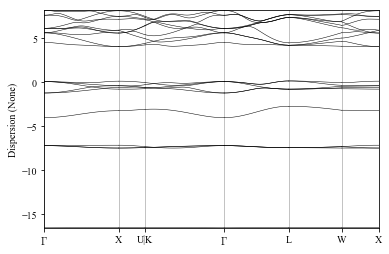

In [147]:
result['bands'].show_mpl()